In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

def gerar_dados_nao_lineares(n_samples=5000, noise_std=0.01):
    """
    Gera dados de entrada (x) e desejado (d) para um sistema não-linear com feedback.
    Sistema: d(k) = d(k-1)/(1 + d(k-1)^2) + x(k)^3
    """
    rng = np.random.default_rng(42)
    x = rng.uniform(-1, 1, n_samples) 
    d = np.zeros(n_samples)
    
    for k in range(1, n_samples):
        nonlinear_feedback = d[k-1] / (1 + d[k-1]**2)
        d[k] = nonlinear_feedback + (x[k]**3) + noise_std * rng.standard_normal()
        
    return x, d

In [2]:
def comparar_ativacoes(x, d, n_neurons=8, step_size=0.005, momentum=0.9):
    """
    Treina dois MLPs (Tanh vs Sigmoid) e retorna os históricos de erro e saída.
    """
    resultados = {}
    ativacoes = ['tanh', 'sigmoid']
    
    print(f"Iniciando comparação com {len(x)} amostras...")
    print(f"Params: Neurônios={n_neurons}, step_size={step_size}, Momentum={momentum}")
    print("-" * 50)

    for act in ativacoes:
        mlp = pdf.MultilayerPerceptron(
            n_neurons=n_neurons,
            input_dim=3,    
            step_size=step_size,
            momentum=momentum,
            activation=act
        )
        
        res = mlp.optimize(x, d, verbose=False)

        mse_final = np.mean(res.errors[-500:]**2)
        mse_db = 10 * np.log10(mse_final)
        
        print(f"Ativação: {act.upper():<8} | MSE Final: {mse_final:.6f} ({mse_db:.2f} dB)")
        
        resultados[act] = {
            'errors': res.errors,
            'outputs': res.outputs,
            'mse_db': mse_db
        }
        
    return resultados

In [3]:
def plotar_comparativo(resultados, d_target, window=50):
    """
    Plota as curvas de aprendizado sobrepostas e o rastreamento final.
    window: tamanho da janela para suavização (Média Móvel) do erro.
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    colors = {'tanh': 'blue', 'sigmoid': 'orange'}
    
    for act, data in resultados.items():
        e_sq = data["errors"]**2
        e_smooth = np.convolve(e_sq, np.ones(window)/window, mode='valid')
        mse_curve = 10 * np.log10(e_smooth + 1e-12)
        
        ax[0].plot(mse_curve, label=f'{act.capitalize()} (Final: {data["mse_db"]:.1f} dB)', 
                   color=colors[act], alpha=0.8, linewidth=1.5)
        
    ax[0].set_title("Comparativo de Convergência: Tanh vs Sigmoid")
    ax[0].set_ylabel("MSE (dB)")
    ax[0].set_xlabel("Iterações")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    
    zoom_samples = 100
    ax[1].plot(d_target[-zoom_samples:], 'k', linewidth=2, label='Desejado', alpha=0.6)
    
    for act, data in resultados.items():
        y_est = data["outputs"][-zoom_samples:]
        ax[1].plot(y_est, '--', label=f'Est. {act.capitalize()}', color=colors[act])
        
    ax[1].set_title(f"Rastreamento de Sinal (Últimas {zoom_samples} amostras)")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Iniciando comparação com 5000 amostras...
Params: Neurônios=12, step_size=0.01, Momentum=0.95
--------------------------------------------------
Ativação: TANH     | MSE Final: 0.028060 (-15.52 dB)
Ativação: SIGMOID  | MSE Final: 0.038458 (-14.15 dB)


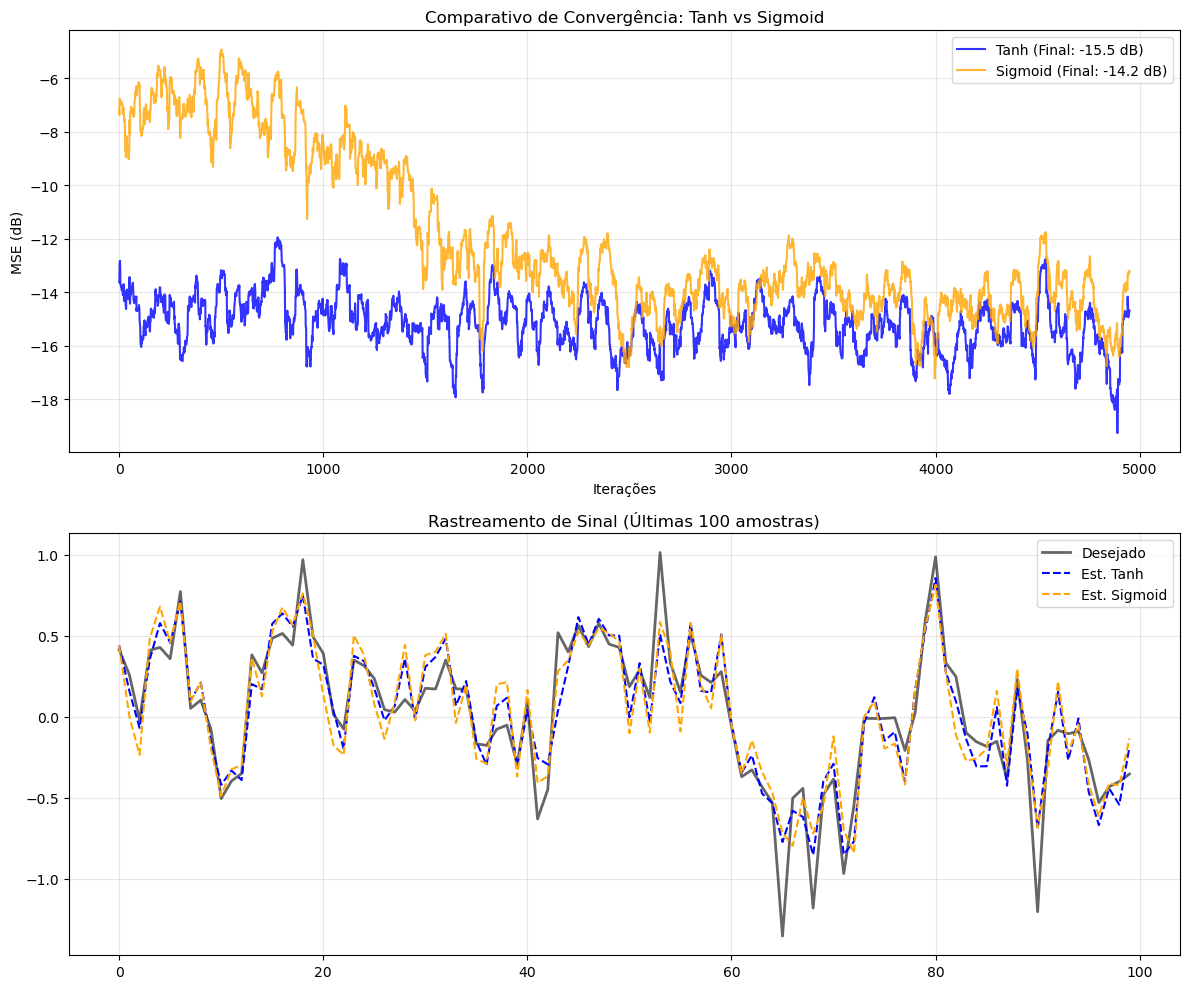

In [4]:
# 1. Gerar Dados
x, d = gerar_dados_nao_lineares(n_samples=5000, noise_std=0.01)

# 2. Rodar o Teste
resultados = comparar_ativacoes(x, d, n_neurons=12, step_size=0.01, momentum=0.95)

# 3. Visualizar
plotar_comparativo(resultados, d)